# Importing Libraries

In [1]:
import nltk
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading Dataset

In [2]:
df=pd.read_csv(r'/content/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preparation

In [3]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
df=df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['v1'].value_counts()

,count
v1,
ham,4825
spam,747


In [6]:
# Separate ham and spam classes
ham = df[df['v1'] == 'ham']
spam = df[df['v1'] == 'spam']

# Randomly sample the ham class
ham_sampled = ham.sample(n=len(spam), random_state=42)  # Match the number of spam entries

# Combine the balanced dataset
df = pd.concat([ham_sampled, spam], axis=0)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(df['v1'].value_counts())


v1
spam    747
ham     747
Name: count, dtype: int64


In [7]:
# """ This triple quotes is a string that spans multiple lines.
def remove_emojis(text):
    """
    Remove emojis from the given text.
    """
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols & pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

In [8]:
def preprocess_text(text):
    """
    Perform preprocessing steps on a given text.
    """
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis
    text = remove_emojis(text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    return ' '.join(tokens)

In [9]:
sample_text = "Lol your always so convincing.! 😍🎥 https://example.com"
processed_text = preprocess_text(sample_text)
print("Original Text: ", sample_text)
print("Processed Text: ", processed_text)

Original Text:  Lol your always so convincing.! 😍🎥 https://example.com
Processed Text:  lol always convincing


In [10]:
cleaned_df=df.copy()
cleaned_df['v2']=cleaned_df['v2'].apply(preprocess_text)
print("cleaned dataset")
cleaned_df.head()

cleaned dataset


,v1,v2
0,spam,urgent important information user today lucky ...
1,spam,panasonic bluetoothhdset free nokia free motor...
2,spam,want new video handset time network min unlimi...
3,spam,hi ur lookin saucy daytime fun wiv busty marri...
4,spam,urgent mobile xxxxxxxxx bonus caller prize nd ...


In [11]:
from collections import Counter

def plot_word_frequency(v2, label, top_n=20):
    """
    Plot the most frequent words for a given label.
    """
    # Combine all v2 for the given label
    combined_text = ' '.join(v2)
    # Tokenize
    words = combined_text.split()
    # Get word frequency
    word_freq = Counter(words).most_common(top_n)
    words, frequencies = zip(*word_freq)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies, color='skyblue')
    plt.title(f"Top {top_n} Words in {label} v2")
    plt.xticks(rotation=45)
    plt.show()

# Data Visualization

Top words in ham v2:


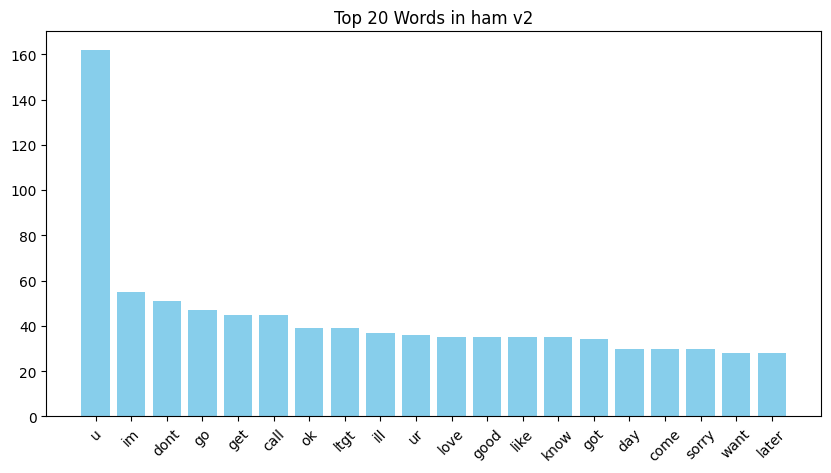

Top words in spam v2:


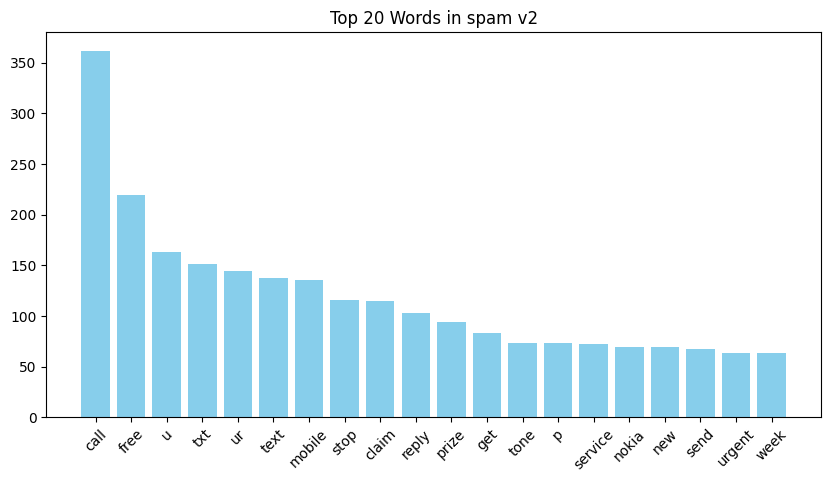

In [12]:
# Step 3: Separate Reviews by Sentiment
ham_v2 = cleaned_df[cleaned_df['v1'] == 'ham']['v2']
spam_v2 = cleaned_df[cleaned_df['v1'] == 'spam']['v2']

# Step 4: Plot Word Frequencies
# Ham v2
print("Top words in ham v2:")
plot_word_frequency(ham_v2, label="ham")

# Spam v2
print("Top words in spam v2:")
plot_word_frequency(spam_v2, label="spam")

In [13]:
# Generate WordCloud for Ham and Spam v2
def generate_wordcloud(v2, label):
    """
    Generate a word cloud for a given set of v2.
    """
    combined_text = ' '.join(v2)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label} Reviews", fontsize=16)
    plt.show()

Word Cloud for Ham v2:


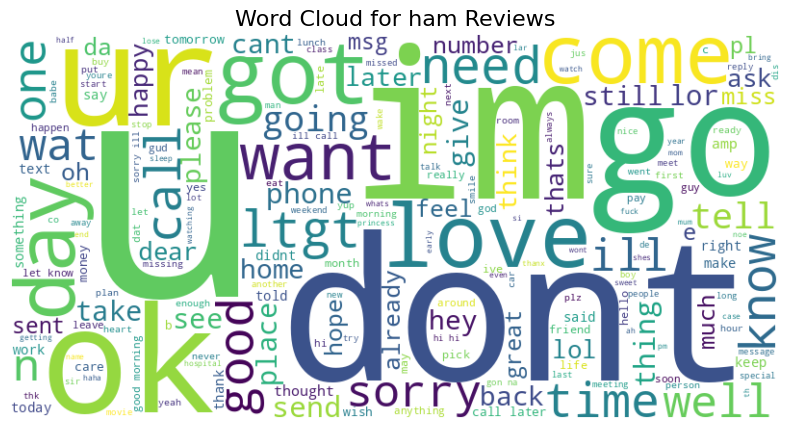

Word Cloud for Spam v2:


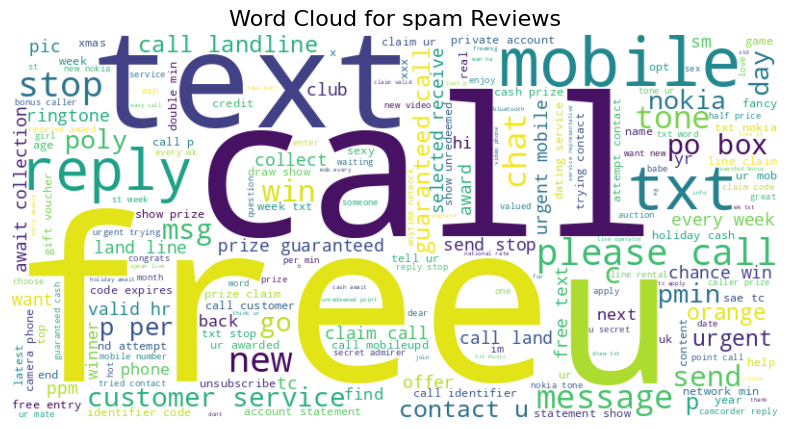

In [14]:
# WordCloud for Ham v2
print("Word Cloud for Ham v2:")
generate_wordcloud(ham_v2, label = "ham")

# WordCloud for Spma v2
print("Word Cloud for Spam v2:")
generate_wordcloud(spam_v2, label = "spam")

# Lable Encoding

In [15]:
# Label Encoding the output
encoder = LabelEncoder()
cleaned_df["v1"] = encoder.fit_transform(cleaned_df["v1"])
print("Encoded dataset")
cleaned_df.head()

Encoded dataset


,v1,v2
0,1,urgent important information user today lucky ...
1,1,panasonic bluetoothhdset free nokia free motor...
2,1,want new video handset time network min unlimi...
3,1,hi ur lookin saucy daytime fun wiv busty marri...
4,1,urgent mobile xxxxxxxxx bonus caller prize nd ...


In [16]:
# split data into input feature and labels
x = cleaned_df['v2']
y = cleaned_df['v1']

In [17]:
def bow_feature_extraction(v1):
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(v1)
    return features, vectorizer

In [18]:
bow_features, bow_vectorizer = bow_feature_extraction(x)
print(bow_features)

  (0, 3237)	1
  (0, 1408)	1
  (0, 1432)	1
  (0, 3246)	1
  (0, 3097)	1
  (0, 1726)	1
  (0, 736)	1
  (0, 1036)	1
  (0, 1676)	1
  (0, 2100)	1
  (0, 994)	1
  (0, 2951)	1
  (0, 214)	1
  (1, 2148)	1
  (1, 326)	1
  (1, 1096)	3
  (1, 2022)	1
  (1, 1925)	1
  (1, 836)	1
  (1, 837)	1
  (1, 2113)	1
  (1, 642)	1
  (1, 420)	2
  (1, 1889)	1
  (1, 2111)	1
  :	:
  (1492, 3237)	1
  (1492, 420)	1
  (1492, 1886)	1
  (1492, 2339)	1
  (1492, 2059)	1
  (1492, 217)	1
  (1492, 1243)	1
  (1492, 1581)	1
  (1492, 1648)	1
  (1492, 557)	1
  (1492, 3258)	1
  (1492, 1366)	1
  (1492, 2306)	1
  (1493, 3316)	1
  (1493, 3081)	1
  (1493, 2858)	1
  (1493, 2969)	1
  (1493, 2010)	1
  (1493, 596)	1
  (1493, 537)	1
  (1493, 1663)	1
  (1493, 59)	1
  (1493, 723)	1
  (1493, 270)	1
  (1493, 2999)	1


In [19]:
def tfidf_feature_extraction(v1):
    vectorizer = TfidfVectorizer()
    features = vectorizer.fit_transform(v1)
    return features, vectorizer

In [20]:
tfidf_features, tfidf_vectorizer = tfidf_feature_extraction(x)
print(tfidf_features)

  (0, 3237)	0.20534499461605177
  (0, 1408)	0.27711598595611725
  (0, 1432)	0.30238592701407463
  (0, 3246)	0.30238592701407463
  (0, 3097)	0.21855627558560015
  (0, 1726)	0.2971738665835882
  (0, 736)	0.20534499461605177
  (0, 1036)	0.24803887297336247
  (0, 1676)	0.29245898441279494
  (0, 2100)	0.30821251485577533
  (0, 994)	0.30821251485577533
  (0, 2951)	0.30238592701407463
  (0, 214)	0.30238592701407463
  (1, 2148)	0.33223291693080054
  (1, 326)	0.33223291693080054
  (1, 1096)	0.41155600841531387
  (1, 2022)	0.1884724217059888
  (1, 1925)	0.2540784939140296
  (1, 836)	0.33223291693080054
  (1, 837)	0.33223291693080054
  (1, 2113)	0.21411097891264821
  (1, 642)	0.2843127518558633
  (1, 420)	0.2100026188134456
  (1, 1889)	0.23888576900261094
  (1, 2111)	0.24735462408303444
  :	:
  (1492, 3237)	0.2648678213327474
  (1492, 420)	0.15360222089245462
  (1492, 1886)	0.2247574213881879
  (1492, 2339)	0.24527710018361862
  (1492, 2059)	0.28061952361645
  (1492, 217)	0.2964734008146886
  (14

# Model Training

In [21]:
x_train, x_test, y_train, y_test = train_test_split(bow_features, y, test_size = 0.2, random_state = 42, shuffle = True)

print("X train Shape: ",x_train.shape)
print ("X Test Shape: ",x_test.shape)
print("Y train Shape: ",y_train.shape)
print("Y Test Shape: ",y_test.shape)

X train Shape:  (1195, 3538)
X Test Shape:  (299, 3538)
Y train Shape:  (1195,)
Y Test Shape:  (299,)


# LogisticRegression

In [22]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
print(lr)

LogisticRegression()


In [23]:
lr_pred = lr.predict(x_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Test Accuracy of LogisticRegression: ",np.round(lr_acc, 2))

Test Accuracy of LogisticRegression:  0.94


# BernoulliNB

In [24]:
ber = BernoulliNB()
ber.fit(x_train, y_train)
print(ber)
ber_pred = ber.predict(x_test)
ber_acc = accuracy_score(y_test, ber_pred)
print("Test Accuracy of BernoulliNB: ",np.round(ber_acc, 2))

BernoulliNB()
Test Accuracy of BernoulliNB:  0.95


# RandomForestClassifier

In [25]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
print(rf)
rf_pred = rf.predict(x_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Test Accuracy of RandomForestClassifier: ",np.round(rf_acc, 2))

RandomForestClassifier()
Test Accuracy of RandomForestClassifier:  0.95


# SVC

In [26]:
svc = SVC()
svc.fit(x_train,y_train)
print(svc)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(y_test, svc_pred)
print("Test Accuracy of SVC: ",np.round(svc_acc, 2))

SVC()
Test Accuracy of SVC:  0.93


In [27]:
# Display Classification Report
class_names = ['Spam', 'Ham']

def cr(name, pred):
    print(f'=> classification report of {name}')
    print(classification_report(y_test, pred, target_names = class_names, digits = 4 ))

cr('LR', lr_pred)
cr('BER', ber_pred)
cr('RF', rf_pred)
cr('SVC', svc_pred)

=> classification report of LR
              precision    recall  f1-score   support

        Spam     0.9157    0.9806    0.9470       155
         Ham     0.9774    0.9028    0.9386       144

    accuracy                         0.9431       299
   macro avg     0.9466    0.9417    0.9428       299
weighted avg     0.9454    0.9431    0.9430       299

=> classification report of BER
              precision    recall  f1-score   support

        Spam     0.9118    1.0000    0.9538       155
         Ham     1.0000    0.8958    0.9451       144

    accuracy                         0.9498       299
   macro avg     0.9559    0.9479    0.9495       299
weighted avg     0.9543    0.9498    0.9496       299

=> classification report of RF
              precision    recall  f1-score   support

        Spam     0.9375    0.9677    0.9524       155
         Ham     0.9640    0.9306    0.9470       144

    accuracy                         0.9498       299
   macro avg     0.9508    0.9491 

# confusion matrix

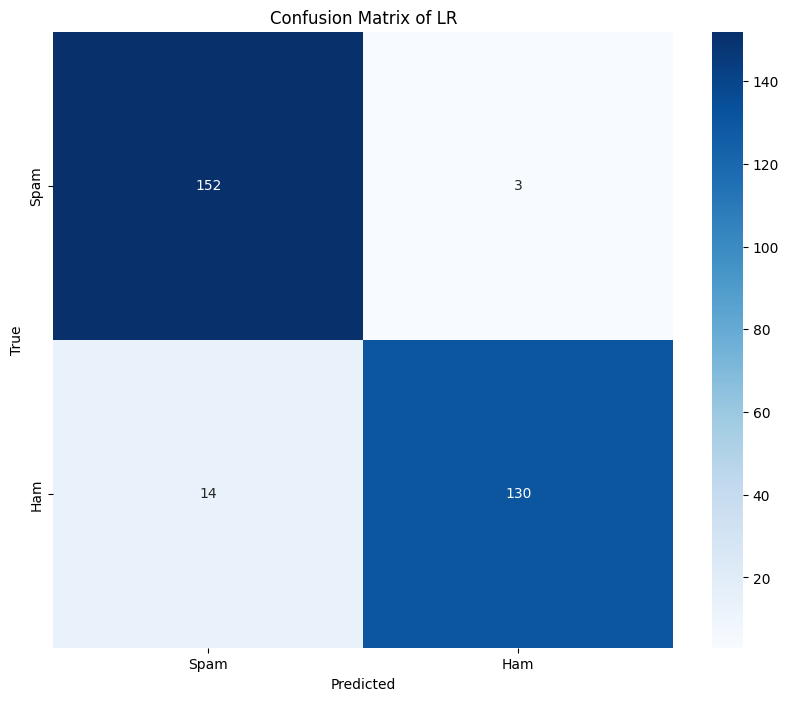

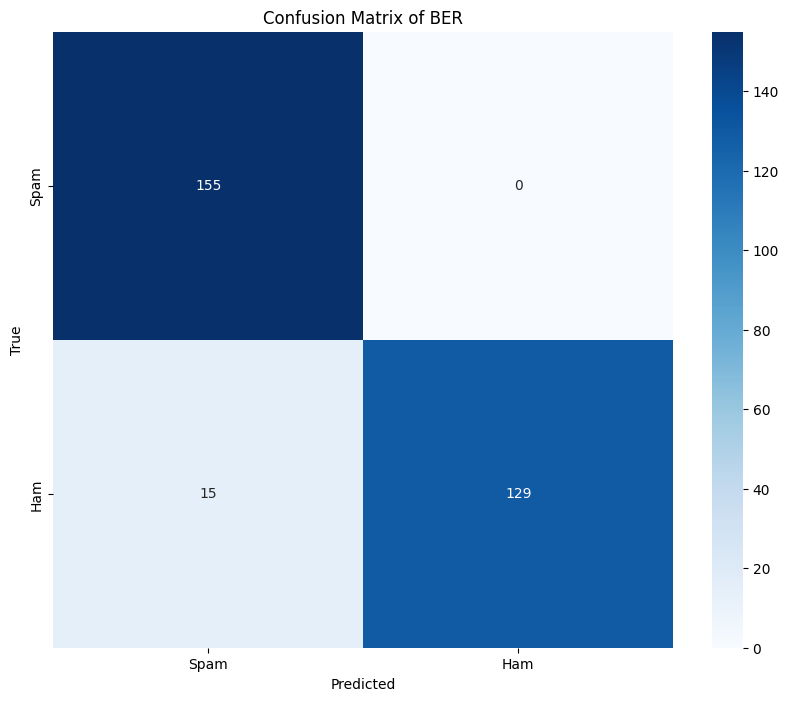

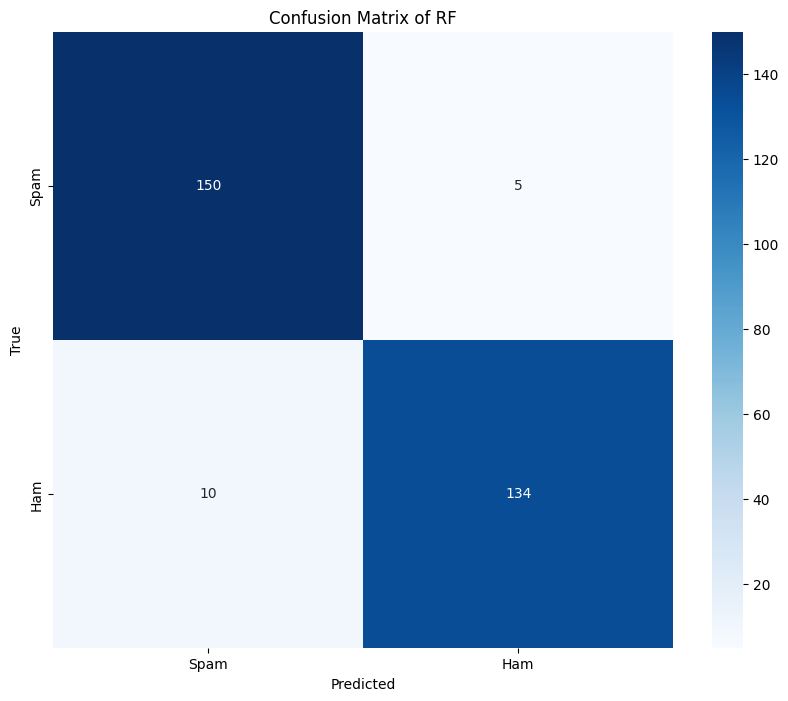

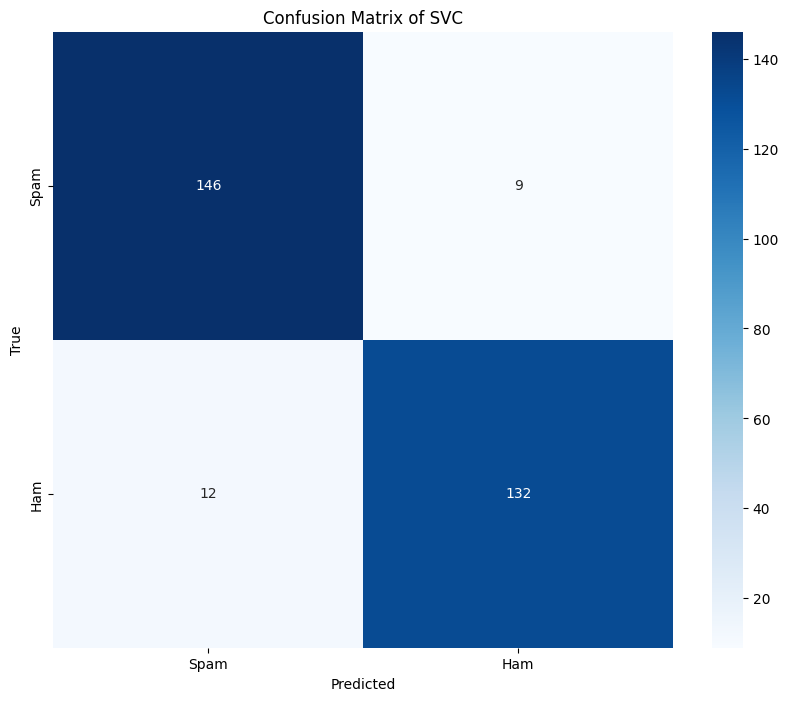

In [28]:
# Plot confusion matrix
def cm(name, pred):
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix of {name}')
    plt.show()

cm('LR', lr_pred)
cm('BER', ber_pred)
cm('RF', rf_pred)
cm('SVC', svc_pred)

In [32]:
best_model_acc = max(lr_acc, ber_acc, rf_acc, svc_acc)
print(f"The best model accuracy is: {np.round(best_model_acc, 2)}")

if best_model_acc == lr_acc:
    best_model = lr
    print(f"The best model is: Logistic Regression")
elif best_model_acc == ber_acc:
    best_model = ber
    print(f"The best model is: Bernoulli Naive Bayes")
elif best_model_acc == rf_acc:
    best_model = rf
    print(f"The best model is: Random Forest")
elif best_model_acc == svc_acc:
    best_model = svc
    print(f"The best model is: Support Vector Classifier")


The best model accuracy is: 0.95
The best model is: Bernoulli Naive Bayes


In [33]:
import pickle

# Save the best model (e.g., Logistic Regression)
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("Model saved successfully!")


Model saved successfully!


In [34]:
# Load the saved model
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")

Model loaded successfully!


# Application Phase

In [41]:
input_text = input("\nEnter a email v2: ")


Enter a email v2: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [42]:
def predict_sentiment(best_model, vectorizer, input_text):
    """
    Predict sentiment for new user input.
    """
    # Preprocess the input text
    processed_text = preprocess_text(input_text)
    # Transform the text using the vectorizer
    transformed_text = vectorizer.transform([processed_text])
    # Predict
    v1 = best_model.predict(transformed_text)
    return "spam" if v1[0] == 1 else "ham"

In [43]:
pred = predict_sentiment(best_model,bow_vectorizer,input_text)
print("v1 = ",pred)

v1 =  spam
